# Validation ActiviySim results

In [15]:
import numpy as np 
import pandas as pd
import os
# import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import geopandas as gpd
import orca
import time
warnings.filterwarnings("ignore")

In [52]:
hdf = pd.HDFStore(path =  'output/pipeline.h5')
pp = hdf['/persons/trip_mode_choice']
hh = hdf['/households/trip_mode_choice']
tours = hdf['/tours/trip_mode_choice']
trips = hdf['/trips/trip_mode_choice']

print ('Number of Households: ',hh.shape[0])
print ('Number of Persons: ',pp.shape[0])
print ('Number of tours: ',tours.shape[0])
print ('Number of trips: ',trips.shape[0])

Number of Households:  666970
Number of Persons:  1657301
Number of tours:  2062190
Number of trips:  5082755


In [53]:
modes_asim = {'DRIVEALONEFREE': "Drive alone",
 'SHARED2FREE': 'Shared ride 2',
 'SHARED3FREE': 'Shared ride 3+',
 'WALK': 'Walk',
 'WALK_LOC': 'Walk to local bus',
 'WALK_LRF': 'Walk to light rail or ferry',
 'BIKE': 'Bicycle',
 'DRIVE_HVY': 'Drive to heavy rail',
 'WALK_HVY': 'Walk to heavy rail',
 'DRIVE_LRF': 'Drive to light rail or ferry',
 'WALK_EXP': 'Walk to express bus',
 'DRIVE_LOC': 'Drive to local bus',
 'DRIVE_EXP': 'Drive to express bus',
 'DRIVEALONEPAY': 'Drive alone',
 'DRIVE_COM': 'Drive to commuter rail',
 'WALK_COM': 'Walk to commuter rail',
 'SHARED2PAY': 'Shared ride 2',
 'SHARED3PAY': 'Shared ride 3+'}

trips = trips.merge(tours[['tour_category']], how = 'left', left_on = 'tour_id', right_index = True )
trips.trip_mode.replace(modes_asim, inplace = True)

In [5]:
def assign_taz(df, gdf):
    '''
    Assigns the gdf index (TAZ ID) for each index in df
    Input: 
    - df columns names x, and y. The index is the ID of the object(blocks, school, college)
    - gdf: Geopandas DataFrame with TAZ as index, geometry and area value. 
    Output:
    A series with df index and corresponding gdf id
    '''
    
    df = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.x, df.y))

    # Spatial join 
    df = gpd.sjoin(df, gdf, how = 'left', op = 'intersects')

    #Drop duplicates and keep the one with the smallest H3 area
    df = df.sort_values('area')
    index_name = df.index.name
    df.reset_index(inplace = True)
    df.drop_duplicates(subset = [index_name], keep = 'first', inplace = True) 
    df.set_index(index_name, inplace = True)
    
    #Check if there is any assigined object
    if df.index_right.isnull().sum()>0:
    
        #Buffer unassigned ids until they reach a hexbin. 
        null_values = df[df.index_right.isnull()].drop(columns = ['index_right','area'])
        result_list = []
        for index, value in null_values.iterrows():
            buff_size = 0.0001
            matched = False
            geo_value = gpd.GeoDataFrame(value).T
            while matched == False:
                geo_value.geometry = geo_value.geometry.buffer(buff_size)
                result = gpd.sjoin(geo_value, gdf, how = 'left', op = 'intersects')
                matched = ~result.index_right.isnull()[0]
                buff_size = buff_size + 0.0001
            result_list.append(result.iloc[0:1])

        null_values = pd.concat(result_list)

        # Concatenate newly assigned values to the main values table 
        df = df.dropna()
        df = pd.concat([df, null_values], axis = 0)

        return df.index_right
    
    else:
        return df.index_right

## Data

In [6]:
zones = gpd.read_file('data/h3_hexbis.shp').set_index('TAZ')
orca.add_table('zones', zones);

In [7]:
hdf = pd.HDFStore('data/model_data.h5')
blocks = hdf['/blocks']
orca.add_table('blocks', blocks);

In [8]:
@orca.column('blocks', cache = True)
def TAZ(blocks, zones):
    blocks_df = blocks.to_frame(columns = ['x', 'y'])
    h3_gpd =  zones.to_frame(columns = ['geometry', 'area'])
    return assign_taz(blocks_df, h3_gpd)

In [23]:
url = 's3://austin-activitysim/base/tx_od_main_JT01_2015.csv'
lodes_ods = pd.read_csv(url, dtype={'w_geocode': str, 'h_geocode': str}, 
                        usecols=['w_geocode', 'h_geocode', 'S000'])

In [ ]:
path = 's3://austin-activitysim/base/A302103 - Means of transportation (18) (Workers 16 years and over).csv'
ctpp_ms = pd.read_csv(path)

In [10]:
%%time
blocks = orca.get_table('blocks').to_frame()

CPU times: user 8.44 ms, sys: 11 µs, total: 8.45 ms
Wall time: 7.48 ms


## Work distance LODES

In [11]:
zones = zones.to_crs(crs={'init': 'EPSG:3081'}) #Name: NAD83 / Texas State Mapping System
zones['centroid'] = zones.geometry.centroid

In [12]:
tours_work = tours[tours.tour_type == 'work']
tours_work = tours_work.merge(zones[['centroid']], how = 'left', 
                              left_on = 'origin', right_index = True)

tours_work = tours_work.merge(zones[['centroid']], how = 'left', 
                              left_on = 'destination', right_index = True,
                              suffixes=('_h', '_w'))

tours_work['distance_m'] = gpd.GeoSeries(tours_work['centroid_h']).\
                          distance(gpd.GeoSeries(tours_work['centroid_w'])) 

In [25]:
blocks = blocks.merge(zones[['centroid']], how = 'left', left_on = 'TAZ', right_index = True )

lodes_ods = lodes_ods.merge(blocks[['TAZ','centroid']], 
                       how = 'inner', 
                       left_on = 'w_geocode', 
                       right_index = True)

lodes_ods = lodes_ods.merge(blocks[['TAZ','centroid']], 
                            how = 'inner', 
                            left_on = 'h_geocode', 
                            right_index = True,
                            suffixes=('_w', '_h'))

lodes_ods['distance_m'] = gpd.GeoSeries(lodes_ods['centroid_h']).\
                          distance(gpd.GeoSeries(lodes_ods['centroid_w']))

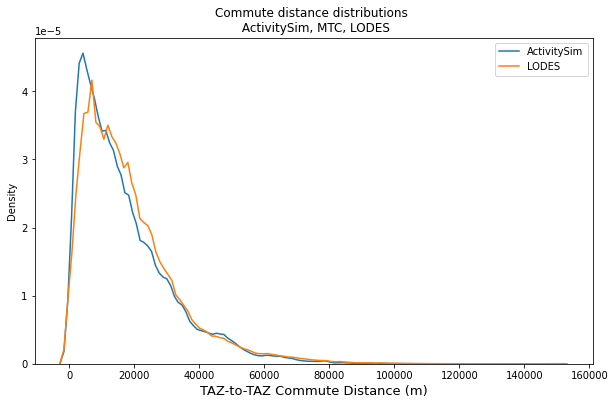

In [30]:
fig, ax = plt.subplots(figsize=(10,6))
sns.kdeplot(tours_work['distance_m'],ax=ax, label='ActivitySim')
sns.kdeplot(lodes_ods['distance_m'], ax=ax, label='LODES')
ax.set_xlabel('TAZ-to-TAZ Commute Distance (m)', fontsize=13)
plt.title('Commute distance distributions \n ActivitySim, MTC, LODES')
plt.ylabel('Density');

## Mode Share

In [58]:
modes_ctpp = {'Car, truck, or van -- Drove alone': 'Car',
         'Car, truck, or van -- In a 2-person carpool': 'Car',
         'Car, truck, or van -- In a 3-person carpool': 'Car',
         'Car, truck, or van -- In a 4-person carpool': 'Car',
         'Car, truck, or van -- In a 5-or-6-person carpool': 'Car',
         'Car, truck, or van -- In a 7-or-more-person carpool': 'Car',
         'Bus or trolley bus': 'Bus', 
         'Streetcar or trolley car': 'Bus',
         'Subway or elevated': 'heavy rail', 
         'Railroad' : 'other', 
         'Ferryboat': 'other', 
         'Bicycle': 'Bike', 
         'Walked': 'Walk',
         'Taxicab': 'other',
         'Motorcycle': 'other',
         'Other method':'other'}

ctpp_ms['ctpp_mode'] = ctpp_ms['Means of Transportation 18'].replace(modes_ctpp)
ctpp_ms.dropna(inplace = True)
ctpp_ms['Workers 16 and Over'] = ctpp_ms['Workers 16 and Over'].astype(int)

mode_share_ctpp = ctpp_ms.groupby('ctpp_mode').sum()
mode_share_ctpp.reset_index(inplace = True)
mask_mode = ~mode_share_ctpp.ctpp_mode.isin(['Auto','Total, means of transportation', 'Worked at home'])
mode_share_ctpp = mode_share_ctpp[mask_mode]
mode_share_ctpp['suma'] = mode_share_ctpp['Workers 16 and Over'].sum()
mode_share_ctpp['mode_share'] = mode_share_ctpp['Workers 16 and Over']/mode_share_ctpp['suma'] 

In [59]:
modes_asim = {'WALK_LRF': 'other', 
              'WALK_LOC': 'Bus', 
              'SHARED3FREE': 'Car', 
              'WALK_COM': 'other',
              'DRIVEALONEFREE': 'Car', 
              'SHARED2FREE':'Car', 
              'BIKE': 'Bike', 
              'DRIVE_LRF': 'other',
              'WALK': 'Walk',
              'WALK_HVY':'heavy rail', 
              'WALK_EXP':'Bus', 
              'DRIVE_LOC': 'Bus', 
              'DRIVE_HVY':'heavy rail', 
              'DRIVE_COM':'other',
              'DRIVEALONEPAY':'Car', 
              'SHARED2PAY':'Car', 
              'DRIVE_EXP': 'Bus',
              'SHARED3PAY':'Car'}

tours['ctpp_mode'] = tours.tour_mode.replace(modes_asim)
tours_work = tours[tours.tour_type == 'work'] # just work trips

mode_share_asim_work = pd.DataFrame(tours_work.groupby('ctpp_mode')['person_id'].count())
mode_share_asim_work['suma'] = mode_share_asim_work['person_id'].sum()
mode_share_asim_work['mode_share'] = mode_share_asim_work['person_id']/mode_share_asim_work['suma'] 
mode_share_asim_work.reset_index(inplace = True)

In [60]:
mode_share_asim_work['model'] = 'Activity Sim'
mode_share_ctpp['model'] = 'CTPP'
join = pd.concat([mode_share_asim_work, mode_share_ctpp])

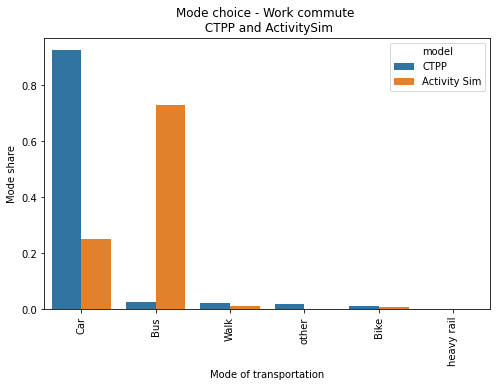

In [61]:
fig, ax = plt.subplots(figsize = (8,5))
sns.barplot(x='ctpp_mode', y='mode_share', hue = 'model', data = join.sort_values('mode_share', ascending=False))
plt.xticks(rotation = 90)
plt.title('Mode choice - Work commute \n CTPP and ActivitySim')
plt.ylabel('Mode share')
plt.xlabel('Mode of transportation');